### FICC Summative


### Initial Set-Up

    1. Reading in Modules
    2. Reading in Data
    3. Helper Functions
        - array2dataframe : converts numpy arrays to dataframes with columns labelled (easier to read)
        

In [ ]:
import numpy as np 
import pandas as pd
from scipy.optimize import minimize

In [2]:
#Reading in the Yield Curve Data and Processing it a bit
excel_file = pd.read_excel('yieldcurve2024 (1).xlsx', index_col= [0])
yield_curve = pd.DataFrame(excel_file.iloc[0,:]) / 100
r0 = yield_curve['Yield'].to_numpy()[0]
rate_vol = 0.0173
log_vol = 0.2142
dt = 0.5


In [242]:
def array2dataframe(array):
    df = pd.DataFrame(array)
    df.index = [j for j in range(0, array.shape[0])]
    df.columns = [i for i in range(0, array.shape[1])]
    df.columns.name = 'Period: i'
    df.index.name = 'State: j'

    return df

In [4]:
def ZCB_Value_Tree(binomial_tree, dt = dt, par_value = 100, test=False):
    ''' 
    Creates value tree for a normal ZCB bond using a given binomial interest rate tree
    '''
    periods = binomial_tree.shape[0]

    #Create Empty Value Tree
    value_tree = np.zeros((periods +1) **2).reshape((periods +1) , (periods +1))   
    #Set Final Layer to Par Value
    value_tree[:, -1] = par_value

    #Backward Induction Loop
    for i in reversed(range(0, periods)):
        for j in range(0, i+1):
            value_tree[j, i] = 0.5 * (value_tree[j, i+1] + value_tree[j+1, i+1]) * np.exp(-binomial_tree[j, i] * dt)

    return value_tree

# MBS 

    These functions compute the value of a fixed-rate mortgage.
        - mortgage_value_no_prepay : calculates the value of the mortgage without option to prepay
        - mortgage_value_prepay : calculates value of prepay option
        - amortisation_schedule : calculates the interest paid, total coupon, and principal/outstanding balance for each period

## Constructing MBS [20 + 20 Marks]


In [234]:
#Chapter 4 Mortgage Example
BDT_Tree_Jan31 = pd.read_csv('Jan31_2000_BDT.csv', index_col = [0]) / 100
BDT_Tree_Jan31 = BDT_Tree_Jan31.to_numpy()
#mortgage_value_no_prepay(periods = 10, rate = 0.07564, binomial_tree=BDT_Tree_Jan31)
#mortgage_value_prepay(periods = 10, rate = 0.07564, binomial_tree=BDT_Tree_Jan31)

In [147]:
Principal = 100000 
rates = np.array([i for i in range(40, 120)]) / 1000
par = {}

In [198]:
# Ho-Lee Model : Par Value
for rate in rates:
    par[rate] = (mortgage_value_no_prepay(periods = 20, rate = rate, binomial_tree=Ho_Lee_Tree)[0])[0,0] - (mortgage_value_prepay(rate = rate, periods = 20, binomial_tree = Ho_Lee_Tree))[0,0]
print(par[0.108])

rate_HL_par = 0.108
V_np = (mortgage_value_no_prepay(periods = 20, rate = rate_HL_par, binomial_tree=Ho_Lee_Tree)[0])[0,0]
V_p = (mortgage_value_prepay(rate = rate_HL_par, periods = 20, binomial_tree = Ho_Lee_Tree))[0,0]
V_np - V_p

100000.0


np.float64(100000.0)

In [199]:
#BDT Model : Par Value

par_BDT = {}
for rate in rates:
    par_BDT[rate] = mortgage_value_no_prepay(periods = 20, rate = rate, binomial_tree = BDT_Tree)[0][0,0] - mortgage_value_prepay(rate = rate, periods = 20, binomial_tree=BDT_Tree)[0,0]

print(par_BDT[0.05])
rate_BDT_par = 0.05  #5% fixed rate
V_np = mortgage_value_no_prepay(periods = 20, rate = rate_BDT_par, binomial_tree = BDT_Tree)[0][0,0]
V_p = mortgage_value_prepay(rate = rate_BDT_par, periods = 20, binomial_tree=BDT_Tree)[0,0]
V_np - V_p

100000.0


np.float64(100000.0)

### Question B
Ho-Lee model's normal distribution, presence of negative interest rates, and smaller probability allocated to higher interest rate states differs from the log-normal, strictly non-negative, and higher interest-rate titled Simple BDT model

Because mortgage prepayment embeds an element of optionality into the security, there is an asymmetric payoff structure that will result in differences when comparing the two models. Simple BDT offers a higher price - intuitively, because lower interest rate environments

BDT Model gives a 5% fixed rate that yields par whereas Ho-Lee model requires a higher fixed rate of 10.8%.

## Question C Fair Valuation of PTS via HL/BDT [20 Marks]

In [200]:


#Mortgage without Prepayment Option
def mortgage_value_no_prepay(rate, dt = dt, periods= 20, principal = Principal, binomial_tree=Ho_Lee_Tree):
    ''' 
    Pricing Mortgage under HL model => assumes optimal prepayment policy. Use
    optimiser/fsolve-based strategy to find the payment rate that gives par/principal
    '''
    interest_paid, principal_paid, outstanding_principal, coupon = mortgage_amortisation_schedule(rate = rate, N = periods, principal = Principal)
    mortgage_tree_no_prepay = np.zeros([periods+1, periods+1])
    mortgage_tree_no_prepay[:, -1] = 0
    
    for i in reversed(range(0, periods)):
        for j in range(0, i + 1):
            mortgage_tree_no_prepay[j, i] = (coupon + 0.5 *(mortgage_tree_no_prepay[j , i + 1] + mortgage_tree_no_prepay[j+1, i+1])) * np.exp(-binomial_tree[j, i] * dt)

    
    return mortgage_tree_no_prepay, interest_paid, principal_paid, outstanding_principal, coupon

def mortgage_value_prepay(rate, dt = dt, periods = 20, principal = Principal, binomial_tree=Ho_Lee_Tree):

    mortgage_tree_no_prepay, interest_paid, principal_paid, outstanding_principal, coupon = mortgage_value_no_prepay(rate = rate, dt = dt, periods = periods, principal = principal, binomial_tree=binomial_tree)
    Mortgage_Tree_With_Prepay = np.zeros([periods, periods])
    for i in reversed(range(0, periods)):
        for j in range(0, i + 1):
            if i == periods -1:
                Value_Wait = (0.5 *(mortgage_tree_no_prepay[j , i + 1] + mortgage_tree_no_prepay[j+1, i+1])) * np.exp(-binomial_tree[j, i] * dt)
                Value_Exercise = np.maximum(0, mortgage_tree_no_prepay[j,i] - outstanding_principal[i])
            if i != periods-1:
                Value_Wait = (0.5 *(Mortgage_Tree_With_Prepay[j , i + 1] + Mortgage_Tree_With_Prepay[j+1, i+1])) * np.exp(-binomial_tree[j, i] * dt)
                Value_Exercise = np.maximum(0, mortgage_tree_no_prepay[j,i] - outstanding_principal[i])
            if Value_Exercise - Value_Wait > 0:
                Mortgage_Tree_With_Prepay[j,i] = np.maximum(Value_Exercise, Value_Wait)
            else:
                Mortgage_Tree_With_Prepay[j,i] = Value_Wait
            
    return Mortgage_Tree_With_Prepay


In [194]:
def mortgage_amortisation_schedule(rate, N = 20, principal = Principal):
    
    periods = np.array([i for i in range(1,N+1)])
    total_coupon = principal / np.sum(1/(1 + rate/2)**periods)

    outstanding_balance = np.zeros(N+1) #Starts at i = 0
    outstanding_balance[0] = principal
    interest_payment_schedule = np.zeros(N) #Starts at i = 1
    principal_payment_schedule = np.zeros(N) #Starts at i = 1
    
    for i in range(N):
        interest_payment = outstanding_balance[i] * rate / 2
        interest_payment_schedule[i] = interest_payment
        
        principal_payment = total_coupon - interest_payment
        outstanding_balance[i+1] = outstanding_balance[i] - principal_payment
        principal_payment_schedule[i] =principal_payment
    
    return interest_payment_schedule, principal_payment_schedule, outstanding_balance, total_coupon

### Pass Through Securities

In [165]:
pass_through_rate_BDT = rate_BDT_par - 0.005
pass_through_rate_HL = rate_HL_par - 0.005

In [201]:
def PTS_mortgage_amortisation_schedule(rate, pass_through_rate, N = 20, principal = Principal):
    
    periods = np.array([i for i in range(1,N+1)])
    total_coupon = principal / np.sum(1/(1 + rate/2)**periods)

    outstanding_balance = np.zeros(N+1) #Starts at i = 0
    outstanding_balance[0] = principal
    interest_payment_schedule = np.zeros(N) #Starts at i = 1
    interest_payment_schedule_pass_through = np.zeros(N)
    principal_payment_schedule = np.zeros(N) #Starts at i = 1
    
    for i in range(N):
        interest_payment_pass_through = outstanding_balance[i] * pass_through_rate/2
        interest_payment_schedule_pass_through[i] = interest_payment_pass_through
        interest_payment = outstanding_balance[i] * rate / 2
        interest_payment_schedule[i] = interest_payment
        
        principal_payment = total_coupon - interest_payment
        outstanding_balance[i+1] = outstanding_balance[i] - principal_payment
        principal_payment_schedule[i] =principal_payment
    
    return interest_payment_schedule_pass_through, principal_payment_schedule, outstanding_balance, total_coupon


In [228]:
def PTS_Value_Tree(rate, pass_through_rate, dt = dt, periods = 20, principal = Principal, binomial_tree=Ho_Lee_Tree):
    
    #Read in PTS amortisation schedule
    interest_schedule, principal_schedule, outstanding_principal, coupon = PTS_mortgage_amortisation_schedule(rate = 
        rate, pass_through_rate=pass_through_rate, N = periods, principal = Principal)

    #Read in Mortgage Tree with no Option to prep

    PTS_Tree = np.zeros([periods+1, periods+1])
    for i in reversed(range(0, periods)):
        for j in range(0, i + 1):
            #print('i:', i, principal_schedule[i], outstanding_principal[i], interest_schedule[i])
            Value_Wait = (0.5 *(PTS_Tree[j , i + 1] + PTS_Tree[j+1, i+1]) + interest_schedule[i] + principal_schedule[i]) * np.exp(-binomial_tree[j, i] * dt)
            PTS_Tree[j,i] = np.minimum(outstanding_principal[i], Value_Wait)
            
    return PTS_Tree

#Test
#array2dataframe(PTS_Value_Tree(rate = 0.07564, pass_through_rate=0.07, periods = 10, binomial_tree=BDT_Tree_Jan31))

In [ ]:
''' 
Pricing using HL and BDT produces very similar result. If the notional was $100,000 the difference is under $10
    => HL Model : $99,391.50
    => BDT Model : $99,358.90
'''
HL_PTS_Pricing = PTS_Value_Tree(rate = rate_HL_par, pass_through_rate=pass_through_rate_HL, periods = 20, binomial_tree=Ho_Lee_Tree)[0,0]
BDT_PTS_Pricing = PTS_Value_Tree(rate = rate_BDT_par, pass_through_rate=pass_through_rate_BDT, periods = 20, binomial_tree=BDT_Tree )[0,0]
HL_PTS_Pricing, BDT_PTS_Pricing

(np.float64(99391.55342276017), np.float64(99358.86014717523))

# Building RN Trees

In [10]:
def Building_Tree(theta,
                  number_of_periods = yield_curve['Yield'].to_numpy().shape[0],
                  r0 = r0,
                  volatility = rate_vol,
                  dt = dt):

 
 #Creating Binomial Tree of length i, height i 
 binomial_tree = np.zeros((number_of_periods , number_of_periods))
 binomial_tree[np.triu_indices(number_of_periods, 0)] = r0
 
 #Apply Ho-Lee
 for i in range(1, number_of_periods): #Time steps from i = 1,2, ... N-1
      for j in range(i + 1):      #States from 0 to i 
            if j == 0:
                previous_rate = binomial_tree[j, i-1]
                binomial_tree[j , i] = previous_rate + theta[i-1]*dt + volatility*np.sqrt(dt)
            else:
                previous_rate = binomial_tree[j-1, i-1]
                binomial_tree[j, i] = previous_rate + theta[i-1]*dt - volatility*np.sqrt(dt)

 return binomial_tree

In [11]:
def Building_Tree_HL_BDT(theta, pricing_model = 'BDT',
                  number_of_periods = yield_curve['Yield'].to_numpy().shape[0],
                  r0 = r0,
                  volatility = log_vol,
                  dt = dt):

 
 #Creating Binomial Tree of length i, height i 
 binomial_tree = np.zeros((number_of_periods , number_of_periods))
 binomial_tree[np.triu_indices(number_of_periods, 0)] = r0
 
 if pricing_model == 'HL':
        for i in range(1, number_of_periods): #Time steps from i = 1,2, ... N-1
            for j in range(i + 1):      #States from 0 to i 
                if j == 0:
                    previous_rate = binomial_tree[j, i-1]
                    binomial_tree[j , i] = previous_rate + theta[i-1]*dt + volatility*np.sqrt(dt)
                else:
                    previous_rate = binomial_tree[j-1, i-1]
                    binomial_tree[j, i] = previous_rate + theta[i-1]*dt - volatility*np.sqrt(dt)
        return binomial_tree
 if pricing_model == 'BDT':
        binomial_tree[0,0] = np.log(r0)  #Initial interest rate is the log of r0
        for i in range(1, number_of_periods): #Same Logic as HL Tree
            for j in range(i + 1):
                if j == 0:
                    previous_rate = binomial_tree[j, i -1]
                    binomial_tree[j,i] = previous_rate + theta[i-1] * dt + volatility*np.sqrt(dt)
                else:
                    previous_rate = binomial_tree[j-1, i-1]
                    binomial_tree[j,i] = previous_rate + theta[i-1]*dt - volatility*np.sqrt(dt)
        binomial_tree = np.exp(binomial_tree)
        return np.triu(binomial_tree)



In [12]:
def ZCB(yield_curve=yield_curve['Yield'].to_numpy(), dt = dt, periods = 50):
     
    ZCB_prices = np.zeros(periods)
    
    for i in range(periods):
        discount_factor = np.exp( - yield_curve[i] * (dt*(i+1)))
        ZCB_prices[i] = 100.00 * discount_factor
    
    return ZCB_prices

ZCB_Prices = ZCB()


In [ ]:
def ZCB_Pricing(binomial_tree, dt = dt, par_value = 100, test=False):
    ''' 
    To calibrate Ho-Lee model, we use backward induction to calculate the price of ZCB bonds.
    This function will be passed through to an optimiser, we can minimise some loss function by comparing this to the true observed
    ZCB prices. This function manually sets the final layer based on the payoff

    Risk neutral probabilities uses q = 0.5
    Parameters :
        1. binomial_tree : Takes in binomial tree from Error Function => Saves time for optimisation
                - Binomial Tree is number of periods x number of periods (includes i = 0)
                - Value tree should have same dimensions but last period (i = maturity) is pay off
        2. theta : theta vector
        3. dt : set to 0.5 years
        4. par value : $100 ZCB 
    ----------
    Returns ZCB_price : present value of cash flows e.g., price of ZCB bond at t = 0
    
    '''

    Model_Prices = []    

    
    for _maturity in reversed(range(0, binomial_tree.shape[0])): #Loops through each maturity (starts at N - 1)
        #Create Value Tree and set last row to $100
        value_tree = np.zeros((_maturity +1) **2).reshape((_maturity +1) , (_maturity +1))                            
        #Sets penultimate node for each maturity
        a = binomial_tree[:, _maturity]
        a = a[a != 0]
        value_tree[:,-1] = par_value * np.exp(-a * dt)                      
        #Backward Induction : start from final node, go backwards to i = 0 period
        for i in range(_maturity-1, -1, -1):

            #Only goes up to when i = j (diagonal)
            for j in range(i+1): 
                #Discounted Expected Value of the bond at time i
                value_tree[j, i] = 0.5 * (value_tree[j, i+1] + value_tree[j+1, i+1]) * np.exp(-binomial_tree[j, i] * dt)

        Model_Prices.append(value_tree[0,0])

    Model_Prices.sort(reverse=True)
    return (Model_Prices)

np.float64(0.017806718377057298)

In [53]:
def Ho_Lee_Model_LossFunction(theta, periods, r0 = r0, volatility = rate_vol, dt = dt, 
                              yield_curve = yield_curve['Yield'].to_numpy()):
    '''  
    This calculates the error function between the Ho-lee model (using initial theta values that 
    are basically random values) and the actual observed ZCB prices calculated from ZCB() function.

    The idea is to use this function in tandem with an optimiser that will fit the theta values by
    minimising this loss function.

    Not the most computationally efficient method but shows the information flow well.

    Loss function used is MSE.
    Uses the short-rate at time = 0 as an initial value (r0)
    '''

    #Get all the ZCB Prices that we are fitting to
    ZCB_observed = ZCB(yield_curve=yield_curve, periods = periods) 
    binomial_tree = Building_Tree(theta = theta, number_of_periods=periods, r0 = r0)

    target_model_price = ZCB_Pricing(binomial_tree = binomial_tree)
    Error_SSE = ((target_model_price - ZCB_observed) ** 2).sum()
    
    return Error_SSE

def calibration_HL(yield_curve = yield_curve['Yield'].to_numpy(), periods = 50, sigma = rate_vol, dt = dt, r0 = yield_curve['Yield'].iloc[0]):
    ''' 
    argmin theta vector of norm-2 errors 

    '''
    initial_guess_theta = np.zeros(periods-1) * 0.01

    #objective function 
    def objective_function(theta):
        return Ho_Lee_Model_LossFunction(theta=theta, periods = periods, r0 = r0, yield_curve=yield_curve)
    
    result = minimize(objective_function, initial_guess_theta, method = 'BFGS',
                      options={
                          'maxiter': 500,
                          'disp': True
                      })
    print(result.success, result.message)

    theta_calibrated = result.x

    return theta_calibrated, result


In [60]:
def BDT_Model_LossFunction(theta, periods, r0 = r0, volatility = log_vol, dt = dt, 
                              yield_curve = yield_curve['Yield']):
    '''  
    This calculates the error function between the Ho-lee model (using initial theta values that 
    are basically random values) and the actual observed ZCB prices calculated from ZCB() function.

    The idea is to use this function in tandem with an optimiser that will fit the theta values by
    minimising this loss function.

    Not the most computationally efficient method but shows the information flow well.

    Loss function used is MSE.
    Uses the short-rate at time = 0 as an initial value (r0)
    '''

    #Get all the ZCB Prices that we are fitting to
    ZCB_observed = ZCB(yield_curve=yield_curve, periods = periods) 
    binomial_tree = Building_Tree_HL_BDT(theta=theta, r0 = r0, number_of_periods=periods, volatility = volatility, pricing_model='BDT')

    target_model_price = ZCB_Pricing(binomial_tree = binomial_tree)
    Error_SSE = ((target_model_price - ZCB_observed) ** 2).sum()
    
    return Error_SSE

def calibration_BDT(yield_curve = yield_curve['Yield'], periods = 50, sigma = log_vol, dt = dt, r0 = yield_curve['Yield'].iloc[0]):
    ''' 
    argmin theta vector of norm-2 errors 

    '''
    initial_guess_theta = np.zeros(periods-1) * 0.01

    #objective function 
    def objective_function(theta):
        return BDT_Model_LossFunction(theta=theta, periods = periods, r0 = r0, yield_curve=yield_curve)
    
    result = minimize(objective_function, initial_guess_theta, method = 'BFGS')
    print(result.success, result.message)

    theta_calibrated = result.x

    return theta_calibrated, result

## Ho Lee & BDT Interest Rate Models

### Ho-Lee Calibration

In [73]:
''' 
Ho-Lee Model Calibration results give us this array of theta values. As we can see, the loss function is on the e-

'''
HL_Thetas_Calibrated = [ 8.42874543e-01, -1.50297530e+00,  4.99974155e-01, -1.42676498e-01,
        2.87073443e-01,  2.26725818e-05,  1.43172295e-01,  2.14521037e-01,
        3.14714143e-02, -6.10380103e-01, -4.32430837e-01,  5.20117962e-01,
        2.85466943e-01,  3.12015500e-01, -2.82835803e-01, -6.28087225e-01,
        3.18260602e-01, -2.84991000e-01,  1.28275638e+00, -5.81895399e-01,
       -8.21348439e-01, -1.15600909e-01,  1.80214570e+00, -1.43170735e+00,
        9.20839288e-01, -1.25321480e+00,  4.26731248e-01,  6.72876663e-01,
        4.11822012e-01, -1.65123213e+00,  1.89571143e+00, -1.22074352e+00,
        2.41200389e-01,  1.52544027e-01, -3.68912415e-01, -4.77569409e-01,
       -1.56273688e-02,  1.22951569e+00, -2.51743077e-01, -1.26980148e+00,
        8.01939905e-01,  2.63279903e-01, -8.67795571e-02,  5.65960174e-01,
       -1.10450062e+00, -1.83961304e-01,  2.53176489e-01,  5.89514740e-01,
        1.77451925e-01]
#Build Tree
Ho_Lee_Tree = (Building_Tree(theta = HL_Calibrated_thetas, number_of_periods=50, r0 = r0))


#Check Loss Function of HL-Calibrated ZCB Prices
Ho_Lee_Model_LossFunction(theta = HL_Thetas_Calibrated, periods = 50, r0 = r0)


np.float64(9.719958022313287e-10)

In [ ]:
HL_Calibrated_thetas, HL_Calibration_results = calibration_HL()

### Simple BDT Calibration

In [68]:
'''
Calibration of BDT Tree returns the below theta values. The error function also shows a good fit with an MSE on order of magnitude of ...
'''
BDT_Tree = Building_Tree_HL_BDT(theta = BDT_Calibrated_Thetas, pricing_model='BDT', number_of_periods=50, r0 = r0)

BDT_Model_LossFunction(theta=BDT_Calibrated_Thetas, periods = 50, r0 = r0, yield_curve=yield_curve['Yield'].to_numpy())

np.float64(2.8324822955410087e-11)

In [64]:
BDT_Calibrated_Thetas = [-0.35166895, -0.12973433, -0.04314289, -0.01995331, -0.01908645,
       -0.023834  , -0.05145382,  0.0006386 ,  0.01834071, -0.02568041,
       -0.0248346 ,  0.04874259, -0.01129887,  0.07052889,  0.00182588,
        0.00292366,  0.00402355,  0.00514153,  0.10679238, -0.0870087 ,
        0.11756801, -0.09304293,  0.12812763, -0.0988221 ,  0.13846138,
       -0.10437622,  0.14856368, -0.1097322 ,  0.01768505,  0.01877134,
        0.01985832,  0.02092173,  0.02197149,  0.02299795, -0.15372942,
        0.19492528,  0.02599841, -0.16412195,  0.01490003,  0.21619626,
       -0.17494786,  0.01720672,  0.01795217,  0.0186364 ,  0.01934527,
        0.02001716,  0.02066254,  0.02130269, -0.2523553 ]
BDT_Results

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.4509054610033418e-11
        x: [-3.517e-01 -1.297e-01 ...  2.130e-02 -2.524e-01]
      nit: 68
      jac: [ 3.669e-06  3.852e-06 ...  2.620e-07  2.278e-07]
 hess_inv: [[ 3.866e-01 -8.171e-01 ... -1.626e-02  4.823e-03]
            [-8.171e-01  2.087e+00 ...  7.501e-02  6.368e-03]
            ...
            [-1.626e-02  7.501e-02 ...  1.268e+01 -9.426e+00]
            [ 4.823e-03  6.368e-03 ... -9.426e+00  1.198e+01]]
     nfev: 3950
     njev: 79

In [61]:
BDT_Calibrated_Thetas, BDT_Results = calibration_BDT(yield_curve=yield_curve['Yield'].to_numpy(), periods = 50, sigma = log_vol, r0 = r0)

True Optimization terminated successfully.


## Testing (based on Veronsi 2011)


In [29]:
test_maturity = [i * 0.5 for i in range(1,12)]
test_price = [99.1338, 97.8925, 96.1462, 94.1011, 91.7136, 89.2258, 86.8142, 84.5016, 82.1848, 79.7718, 77.4339]
test_yields = [1.74, 2.13, 2.62, 3.04, 3.46, 3.80, 4.04, 4.21, 4.36, 4.52, 4.65]
test_yields = np.array(test_yields) / 100

HL_thetas_Veronsi = [0.015675, 0.021824, 0.014374, 0.017324, 0.007873, 0.000423, -0.000628, 0.004322, 0.009271, 0.001202]
BDT_thetas_Veronsi = [0.7182, 0.6916, 0.3348, 0.3379, 0.1182, -0.0230, -0.0438, 0.0455, 0.1281, -0.0126]

### Ho Lee & BDT Testing

In [30]:
#The ZCB prices on Jan 8 2002 yields by HL model is calibrated
ZCB_Pricing(binomial_tree=
            Building_Tree_HL_BDT(theta = HL_thetas_Veronsi, r0 = 0.0174, number_of_periods=11,
                                 pricing_model='HL', volatility=rate_vol))

[np.float64(99.13377354877926),
 np.float64(97.8925199386555),
 np.float64(96.1462252342918),
 np.float64(94.10115336419449),
 np.float64(91.71356656896344),
 np.float64(89.22581300642932),
 np.float64(86.81421561300095),
 np.float64(84.50159655485554),
 np.float64(82.1847992420609),
 np.float64(79.77181542525089),
 np.float64(77.43389845384934)]

In [31]:
#Same for BDT
ZCB_Pricing(binomial_tree=
            Building_Tree_HL_BDT(theta = BDT_thetas_Veronsi, r0 = 0.0174, number_of_periods=11,
                                 pricing_model='BDT', volatility=log_vol))

[np.float64(99.13377354877926),
 np.float64(97.89251115240728),
 np.float64(96.14619487906887),
 np.float64(94.10112103555397),
 np.float64(91.71356114129568),
 np.float64(89.22581444604727),
 np.float64(86.8142650682546),
 np.float64(84.50169495072147),
 np.float64(82.18495319871649),
 np.float64(79.77198342904671),
 np.float64(77.43406589895683)]

In [34]:
#Optimiser to find Thetas work 
HL_Veronsi_Calibrated_Thetas, HL_V_Result = calibration_HL(yield_curve=test_yields, periods = 11, r0 = 0.0174 )
BDT_Veronsi_Calibrated_Thetas, BDT_V_Result = calibration_BDT(yield_curve=test_yields, periods = 11, r0 = 0.0174)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 319
         Gradient evaluations: 29
True Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 275
         Gradient evaluations: 25
True Optimization terminated successfully.


In [35]:
#Error Function (MSE) confirms HL model pricing is accurate
Ho_Lee_Model_LossFunction(theta = HL_Veronsi_Calibrated_Thetas, periods = 11, r0 = 0.0174, yield_curve=test_yields)

np.float64(2.777278530248302e-11)

In [36]:
#Error Function also confirms BDT model is accurate
BDT_Model_LossFunction(theta = BDT_Veronsi_Calibrated_Thetas, periods = 11, r0 = 0.0174, volatility = log_vol, yield_curve = test_yields)

np.float64(2.3584272854215594e-12)

## Monte Carlo

### Simulating MC Interest Rates

In [342]:
def monte_carlo_simulation(tree, paths):
    #Create simulation table (number of periods x number of simulations)
    simulation = np.zeros([paths, tree.shape[0]])
    #Set the initial node to interest rate at i = 0
    simulation[:, 0] = tree[0,0]
    #Loop over each simulation
    for path in range(0, simulation.shape[0]):
        rate = 0
        p = 0
        counter = 0

        for period in range(1, simulation.shape[1]):
            p = np.random.rand() #Random engine

            if p > 0.5: #Up move 
                simulation[path, period] = tree[rate, counter + 1]
                rate = rate
                counter += 1
            else:
                simulation[path, period] = tree[rate, counter + 1]
                rate = rate + 1
                counter += 1
    
    return simulation

In [ ]:
#BDT Monte Carlo Simulation of Interest Rate Tree
MC_BDT = pd.DataFrame(monte_carlo_simulation(tree = BDT_Tree, paths = 100000) * 100)

In [351]:
#Ho-Lee Monte Carlo Simulation of Interest Rate Tree
MC_HL = pd.DataFrame(monte_carlo_simulation(tree = Ho_Lee_Tree, paths = 100000) * 100)

In [353]:
#Index and Columns
MC_BDT.index = np.arange(0, 100000)
MC_BDT.index.name = 'Simulations'
MC_BDT.columns.name = 'Period'
MC_HL.index = np.arange(0, 100000)
MC_HL.index.name = 'Simulations'
MC_HL.columns.name = 'Periods'
#Interest Rate Realisations at i = 50
MC_BDT_Realisations = MC_BDT.iloc[:, -1]
MC_HL_Realisations = MC_HL.iloc[:, -1]


In [312]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Monte Carlo Simulation of 100000 Runs'}, xlabel='Interest Rate', ylabel='Number of Occurences'>

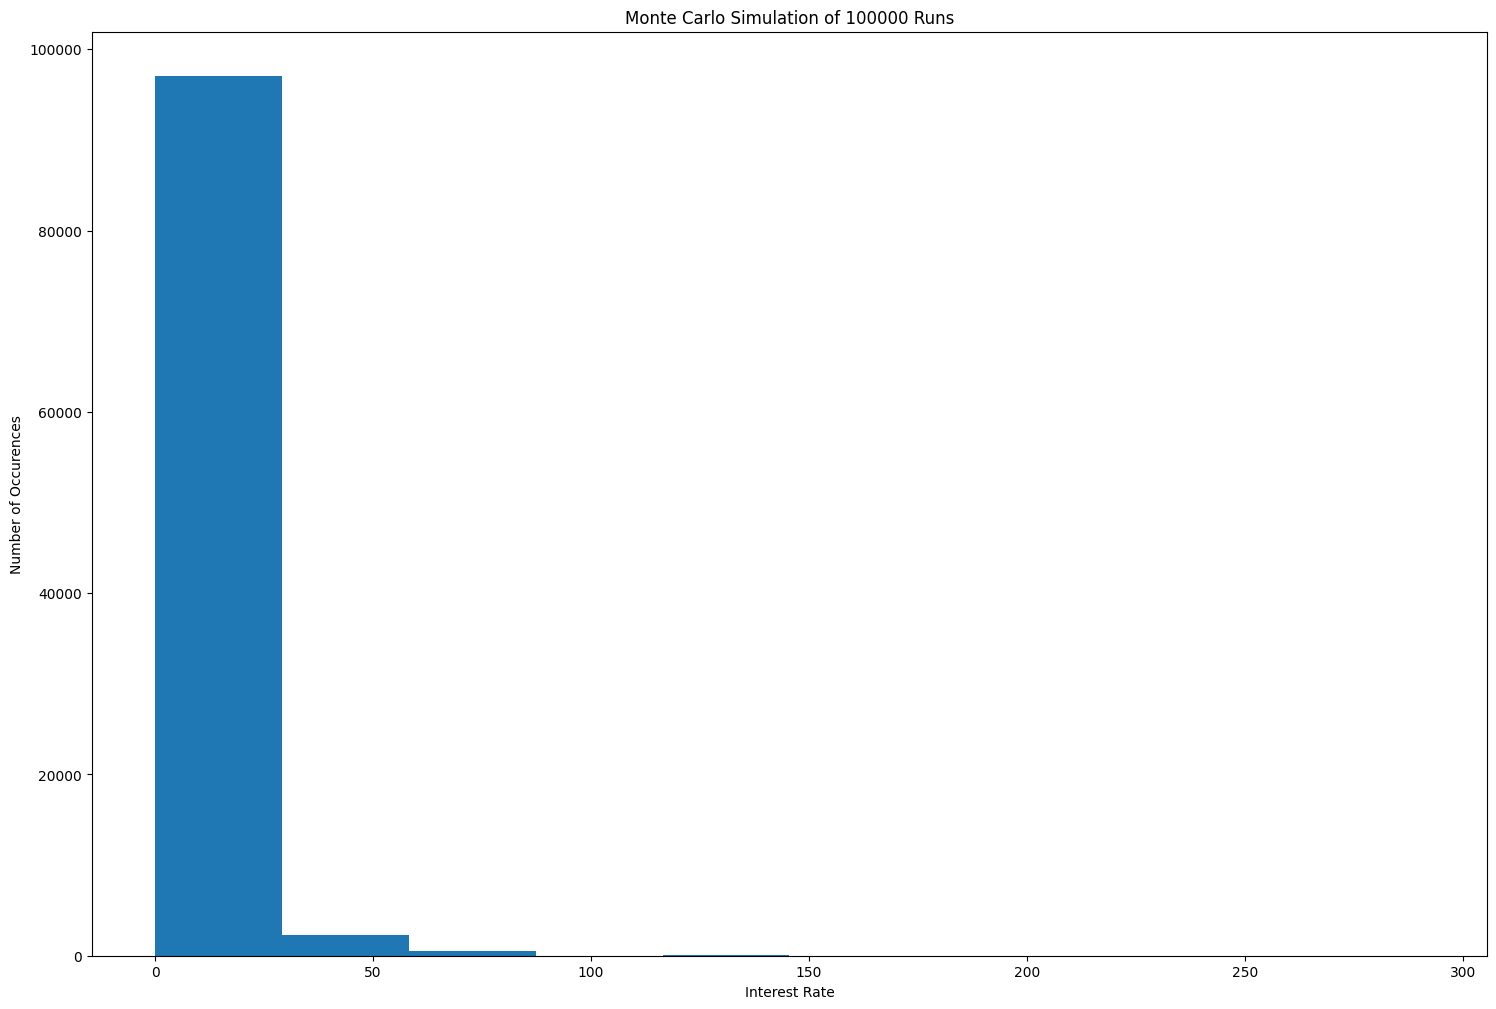

In [352]:
MC_BDT_Realisations.plot.hist(
    figsize = (18, 12),
    xlabel = 'Interest Rate',
    ylabel= 'Number of Occurences',
    title = f'Monte Carlo Simulation of {N} Runs')

<Axes: title={'center': '100 Simulations of BDT Tree'}, xlabel='Periods', ylabel='Interest Rate'>

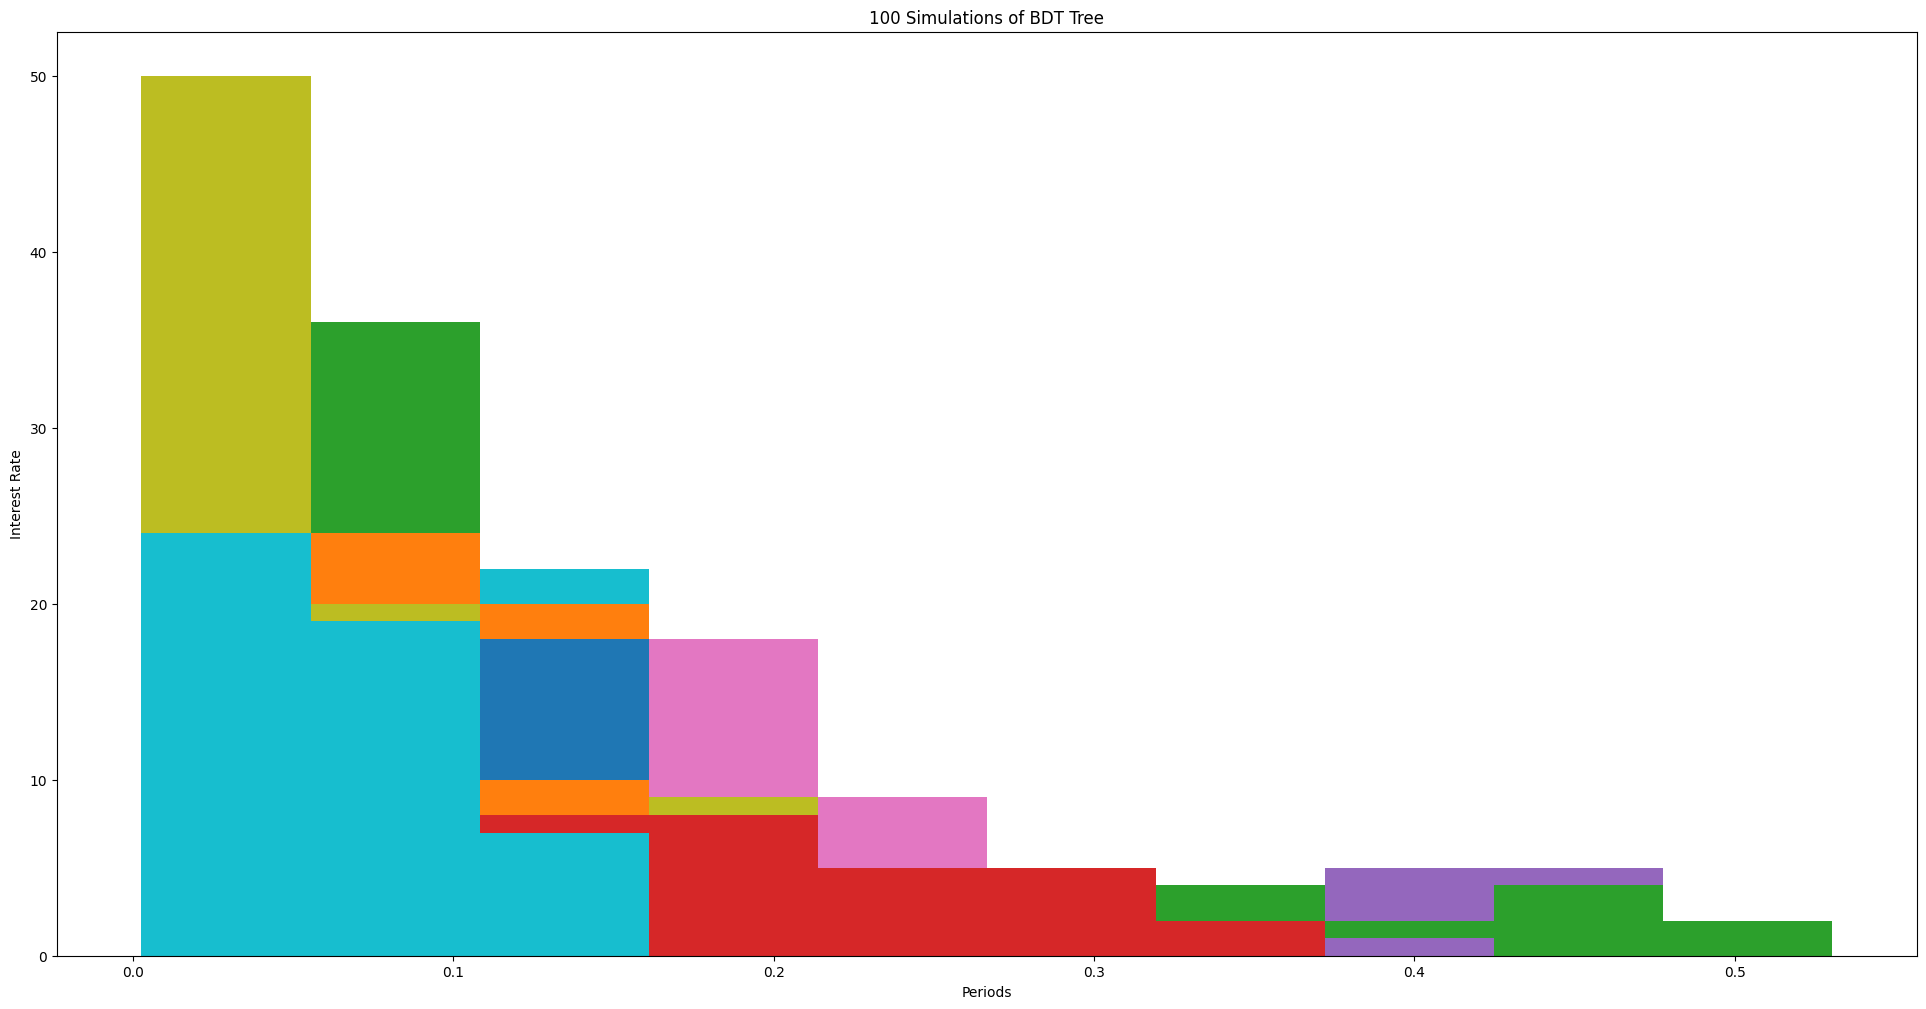

In [311]:
fig,ax = plt.subplots(figsize=(24, 12))
N = 100
MC.plot.hist(ax = ax, legend=None, xlabel = 'Periods', ylabel = 'Interest Rate', title = f'{N} Simulations of BDT Tree')